In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import util as ut
import numpy as np
import os
import jams
import librosa
import matplotlib.pyplot as plt
import madmom

In [6]:
p = '/scratch/qx244/data/gskey/augmentation'

In [7]:
file_list = ut.glob(os.path.join(p, '*.npy'))

In [8]:
len(file_list)

6612

In [9]:
def softmax(mat):
    """shape: x * 12"""
    e = np.exp(mat)
    return e / np.sum(e, axis=1, keepdims=True)

def key_marg_simple_add(key_output):
    """bin 0 is A, bin 1 is Bb, bin 11 is G#"""
    return key_output[:, :12] + key_output[:, 12:]

def key_marg_add_logit(key_output):
    """bin 0 is A, bin 1 is Bb, bin 11 is G#"""
    z = np.log(key_output)
    return softmax(z[:, :12] + z[:, 12:])

In [16]:
madmom.features.key.KEY_LABELS

['A major',
 'Bb major',
 'B major',
 'C major',
 'Db major',
 'D major',
 'Eb major',
 'E major',
 'F major',
 'F# major',
 'G major',
 'Ab major',
 'A minor',
 'Bb minor',
 'B minor',
 'C minor',
 'C# minor',
 'D minor',
 'D# minor',
 'E minor',
 'F minor',
 'F# minor',
 'G minor',
 'G# minor']

In [10]:
pred_list = []
label_list = []
for f in file_list:
    jams_path = f.rsplit('.', 1)[0] + '.jams'
    pred_list.append(np.load(f))
    jam = jams.load(jams_path)
    tonic = jam.search(namespace='key_mode')[0].to_dataframe().value[0]
    label_list.append((librosa.note_to_midi(tonic)) % 12)


In [11]:
pred_all = np.concatenate(pred_list, axis=0)
label_all = (np.array(label_list) + 3) % 12 # So that bin 0 is A to match with madmom

In [16]:
label_all[3]

8

In [12]:
folded_pred_all = key_marg_add_logit(pred_all)

In [13]:
added_pred_all = key_marg_simple_add(pred_all)

In [23]:
hard_max_pred_all = ut.key_marg_hard_max(pred_all)

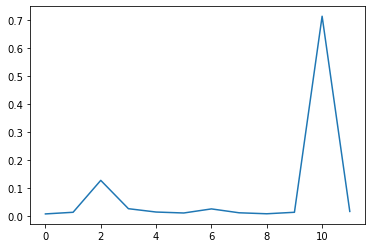

In [24]:
plt.plot(hard_max_pred_all[11])

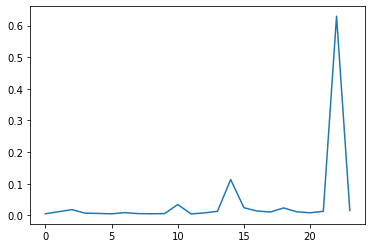

In [17]:
plt.figure()
plt.plot(pred_all[11])

In [19]:
rc = ut.RockCorpus()
rc.titles[11]

'when_doves_cry'

In [21]:
label_all[11]

10

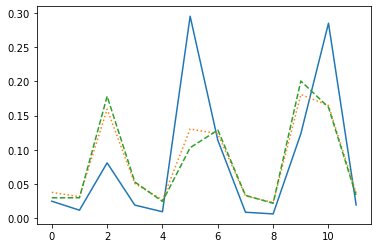

In [26]:
idx = 12
plt.figure()
plt.plot(folded_pred_all[idx])
plt.plot(added_pred_all[idx], ":")
plt.plot(hard_max_pred_all[idx], "--")

In [82]:
from scipy.optimize import minimize_scalar

In [96]:
logit_res = minimize_scalar(ut.better_track_nll, 
                            args=(label_all, folded_pred_all),
                            bounds=(0, 1),
                            method='bounded')

In [97]:
logit_res

     fun: 0.5278569629522144
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.7806331984345791

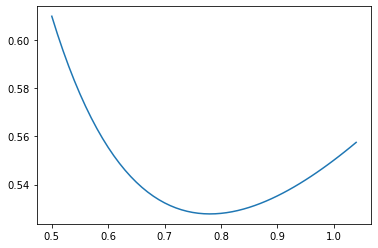

In [98]:
plt.plot(np.arange(0.5,1.05,0.01),
         [ut.better_track_nll(b, label_all, folded_pred_all) 
          for b in np.arange(0.5, 1.05, 0.01)])

In [99]:
added_res = minimize_scalar(ut.better_track_nll, 
                      args=(label_all, added_pred_all),
                      bounds=(0, 2),
                      method='bounded')

In [102]:
added_res

     fun: 0.5321072002952392
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 1.2068284903223008

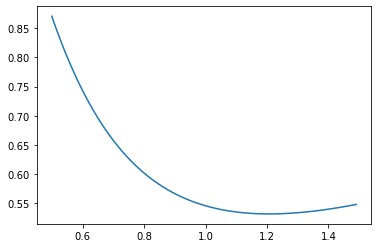

In [101]:
plt.plot(np.arange(0.5, 1.5, 0.01),
         [ut.better_track_nll(b, label_all, added_pred_all) 
          for b in np.arange(0.5, 1.5, 0.01)])

In [103]:
folded_pred_calib = ut.better_calibrate(logit_res.x, folded_pred_all)
added_pred_calib = ut.better_calibrate(added_res.x, added_pred_all)

In [114]:
logit_original = ut.CalibrationBenchmark(folded_pred_all, label_all, m=15)
logit_calibrated = ut.CalibrationBenchmark(folded_pred_calib, label_all, m=15)
added_original = ut.CalibrationBenchmark(added_pred_all, label_all, m=15)
added_calibrated = ut.CalibrationBenchmark(added_pred_calib, label_all, m=15)

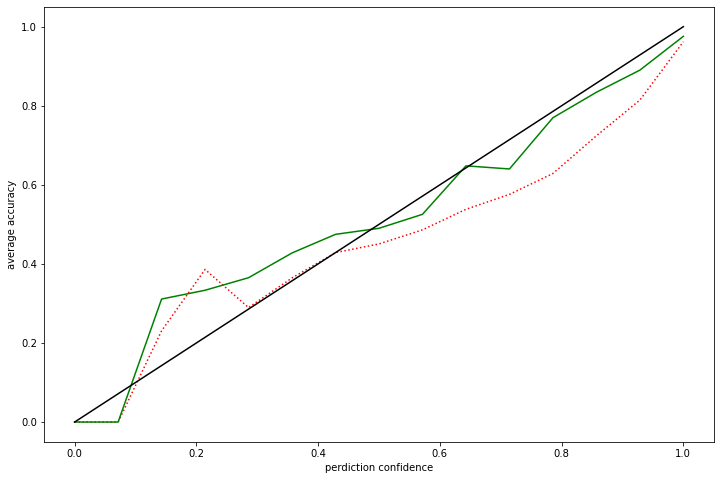

In [110]:
bins = np.linspace(0, 1, num=15, endpoint=True)
plt.figure(figsize=(12,8))
plt.plot(bins, logit_original.bin_accuracy(), 'r:')
plt.plot(bins, logit_calibrated.bin_accuracy(), 'g')
plt.plot(bins, bins, 'k')
plt.xlabel('perdiction confidence')
plt.ylabel('average accuracy')
plt.show()

In [111]:
logit_original.ece()

0.048220957475072365

In [112]:
logit_calibrated.ece()

0.01780335207203051

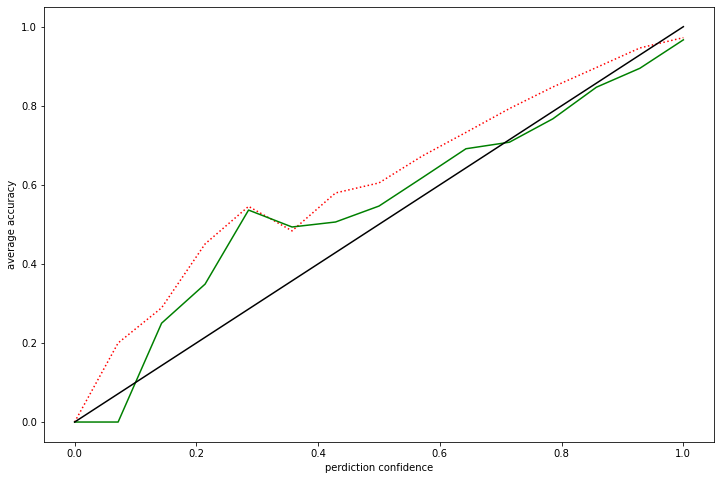

In [115]:
bins = np.linspace(0, 1, num=15, endpoint=True)
plt.figure(figsize=(12,8))
plt.plot(bins, added_original.bin_accuracy(), 'r:')
plt.plot(bins, added_calibrated.bin_accuracy(), 'g')
plt.plot(bins, bins, 'k')
plt.xlabel('perdiction confidence')
plt.ylabel('average accuracy')
plt.show()

In [116]:
added_original.ece()

0.057454659563644817

In [117]:
added_calibrated.ece()

0.029977695216034085